<a href="https://colab.research.google.com/github/cheungngo/DeepLearning/blob/master/TensorFlow_advanced_io/C4_W4_Assignment_hand_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 Assignment: GANs with Hands


For the last programming assignment of this course, you will build a Generative Adversarial Network (GAN) that generates pictures of hands. These will be trained on a dataset of hand images doing sign language.

The model you will build will be very similar to the DCGAN model that you saw in the second ungraded lab of this week. Feel free to review it in case you get stuck with any of the required steps.

***Important:*** *This colab notebook has read-only access so you won't be able to save your changes. If you want to save your work periodically, please click `File -> Save a Copy in Drive` to create a copy in your account, then work from there.*  

## Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt
import numpy as np

import urllib.request
import zipfile
from IPython import display

## Utilities

In [2]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Get the training data

You will download the dataset and extract it to a directory in your workspace. As mentioned, these are images of human hands performing sign language.

In [3]:
# download the dataset
training_url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Resources/signs-training.zip"
training_file_name = "signs-training.zip"
urllib.request.urlretrieve(training_url, training_file_name)

# extract to local directory
training_dir = "/tmp"
zip_ref = zipfile.ZipFile(training_file_name, 'r')
zip_ref.extractall(training_dir)
zip_ref.close()

## Preprocess the images

Next, you will prepare the dataset to a format suitable for the model. You will read the files, convert it to a tensor of floats, then normalize the pixel values.

In [4]:
BATCH_SIZE = 32

# mapping function for preprocessing the image files
def map_images(file):
  '''converts the images to floats and normalizes the pixel values'''
  img = tf.io.decode_png(tf.io.read_file(file))
  img = tf.dtypes.cast(img, tf.float32)
  img = img / 255.0
  
  return img

# create training batches
filename_dataset = tf.data.Dataset.list_files("/tmp/signs-training/*.png")
image_dataset = filename_dataset.map(map_images).batch(BATCH_SIZE)

## Build the generator

You are free to experiment but here is the recommended architecture:
- *Dense*: number of units should equal `7 * 7 * 128`, input_shape takes in a list containing the random normal dimensions.
    - `random_normal_dimensions` is a hyperparameter that defines how many random numbers in a vector you'll want to feed into the generator as a starting point for generating images.
- *Reshape*: reshape the vector to a 7 x 7 x 128 tensor.
- *BatchNormalization*
- *Conv2DTranspose*: takes `64` units, kernel size is `5`, strides is `2`, padding is `SAME`, activation is `selu`.
- *BatchNormalization*
- *Conv2DTranspose*: `1` unit, kernel size is `5`, strides is `2`, padding is `SAME`, and activation is `tanh`.

In [6]:
# You'll pass the random_normal_dimensions to the first dense layer of the generator
random_normal_dimensions = 32

### START CODE HERE ###
generator = keras.models.Sequential([
    tf.keras.layers.Dense(7*7*128, input_shape = [random_normal_dimensions]),
    tf.keras.layers.Reshape([7,7,128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding = "same", activation="selu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding = "same", activation = "tanh")  
])
### END CODE HERE ###

## Build the discriminator

Here is the recommended architecture for the discriminator:
- *Conv2D*: 64 units, kernel size of 5, strides of 2, padding is SAME, activation is a leaky relu with alpha of 0.2, input shape is 28 x 28 x 1
- *Dropout*: rate is 0.4 (fraction of input units to drop)
- *Conv2D*: 128 units, kernel size of 5, strides of 2, padding is SAME, activation is LeakyRelu with alpha of 0.2
- *Dropout*: rate is 0.4.
- *Flatten*
- *Dense*: with 1 unit and a sigmoid activation

In [9]:
### START CODE HERE ###
discriminator = keras.models.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation = keras.layers.LeakyReLU(0.4), input_shape = [28,28,1]),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation = keras.layers.LeakyReLU(0.4)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation = "sigmoid")  
])
### END CODE HERE ###

## Compile the discriminator

- Compile the discriminator with a binary_crossentropy loss and rmsprop optimizer.
- Set the discriminator to not train on its weights (set its "trainable" field).

In [10]:
### START CODE HERE ###
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
### END CODE HERE ###

## Build and compile the GAN model

- Build the sequential model for the GAN, passing a list containing the generator and discriminator.
- Compile the model with a binary cross entropy loss and rmsprop optimizer.

In [11]:
### START CODE HERE ###
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
### END CODE HERE ###

## Train the GAN

Phase 1
- real_batch_size: Get the batch size of the input batch (it's the zero-th dimension of the tensor)
- noise: Generate the noise using `tf.random.normal`.  The shape is batch size x random_normal_dimension
- fake images: Use the generator that you just created. Pass in the noise and produce fake images.
- mixed_images: concatenate the fake images with the real images.
  - Set the axis to 0.
- discriminator_labels: Set to `0.` for fake images and `1.` for real images.
- Set the discriminator as trainable.
- Use the discriminator's `train_on_batch()` method to train on the mixed images and the discriminator labels.


Phase 2
- noise: generate random normal values with dimensions batch_size x random_normal_dimensions
  - Use `real_batch_size`.
- Generator_labels: Set to `1.` to mark the fake images as real
  - The generator will generate fake images that are labeled as real images and attempt to fool the discriminator.
- Set the discriminator to NOT be trainable.
- Train the GAN on the noise and the generator labels.

In [14]:

def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        for real_images in dataset:
            
### START CODE HERE ###
            # infer batch size from the current batch of real images
            real_batch_size = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal([real_batch_size, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([real_images, fake_images], axis = 0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([1.] * real_batch_size + [0.] * real_batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal([real_batch_size, random_normal_dimensions])
            
            # label all generated images to be "real"
            generator_labels = tf.constant([1.] * real_batch_size)
            
            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
            
### END CODE HERE ###
        plot_results(fake_images, 16)                     
        plt.show()
    return fake_images

### Run the training

For each epoch, a set of 31 images will be displayed onscreen. The longer you train, the better your output fake images will be. You will pick your best images to submit to the grader.

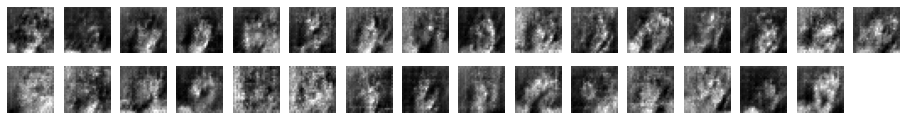

In [17]:
# you can adjust the number of epochs
EPOCHS = 100

# run the training loop and collect images
fake_images = train_gan(gan, image_dataset, random_normal_dimensions, EPOCHS)

## Choose your best images to submit for grading!

Please visually inspect your 31 generated hand images.  They are indexed from 0 to 30, from left to right on the first row on top, and then continuing from left to right on the second row below it.

- Choose 16 images that you think look most like actual hands.
- Use the `append_to_grading_images()` function, pass in `fake_images` and a list of the indices for the 16 images that you choose to submit for grading (e.g. `append_to_grading_images(fake_images, [1, 4, 5, 6, 8... until you have 16 elements])`).

In [18]:
# helper function to collect the images
def append_to_grading_images(images, indexes):
  l = []
  for index in indexes:
    if len(l) >= 16:
      print("The list is full")
      break
    l.append(tf.squeeze(images[index:(index+1),...], axis=0))
  l = tf.convert_to_tensor(l)
  return l

Please fill in the empty list (2nd parameter) with 16 indices indicating the images you want to submit to the grader.

In [23]:
grading_images = append_to_grading_images(fake_images, [2,3,11,13,14,15,16,17,18,19,20,21,22,27,28,30])

## Zip your selected images for grading

Please run the code below. This will save the images you chose to a zip file named `my-signs.zip`.

- Please download this file from the Files explorer on the left.
- Please return to the Coursera classroom and upload the zip file for grading.

In [24]:
from PIL import Image
from zipfile import ZipFile

denormalized_images = grading_images * 255
denormalized_images = tf.dtypes.cast(denormalized_images, dtype = tf.uint8)

file_paths = []

for this_image in range(0,16):
  i = tf.reshape(denormalized_images[this_image], [28,28])
  im = Image.fromarray(i.numpy())
  im = im.convert("L")
  filename = "hand" + str(this_image) + ".png"
  file_paths.append(filename)
  im.save(filename)

with ZipFile('my-signs.zip', 'w') as zip:
  for file in file_paths:
    zip.write(file)

**Congratulations on completing the final assignment of this course!**